# Predict The Optimum Number Of Clusters Required & Classify The Species.

> #### **Language used:** Python

> #### **Models used:** K - Means, K - Nearest Neighbor, Support Vector Classifier, Decision Tree

# Loading Libraries & Importing Dataset

In [1]:
import warnings
!pip install dtreeviz
warnings.filterwarnings("ignore")
#!apt-get install graphviz

     |████████████████████████████████| 62 kB 323 kB/s 
     |████████████████████████████████| 46 kB 1.6 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.2-py3-none-any.whl size=67923 sha256=fd865fbddbbc1ce4bdc068d5b515a0ae41df28c6bafc2f2a0389c8b9f4d617ef
  Stored in directory: /root/.cache/pip/wheels/9d/29/a1/f2ad20de79875e749330d5c6234fc5f517991fcaa23d7a3d0f
Successfully built dtreeviz
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.8.0.post0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.19.1 which is incompatible.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from dtreeviz.trees import dtreeviz 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix

In [3]:
data = pd.read_csv("../input/iris-dataset/Iris.csv")
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Dataset Information
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


> Total features: 6 

> Target Fetaure for Classification: Species

## Data Preprocessing

In [5]:
# Checking for missing records
data.isnull().sum() 

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

> There are no missing values in the data

# Exploratory Data Analysis

### Analysing Target Feature - Species

In [6]:
data['Species'].value_counts()

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: Species, dtype: int64

> Levels: 3

> Types of Species - Setosa, Versicolor & Virginica 

> Each Level has 50 records

### Histograms

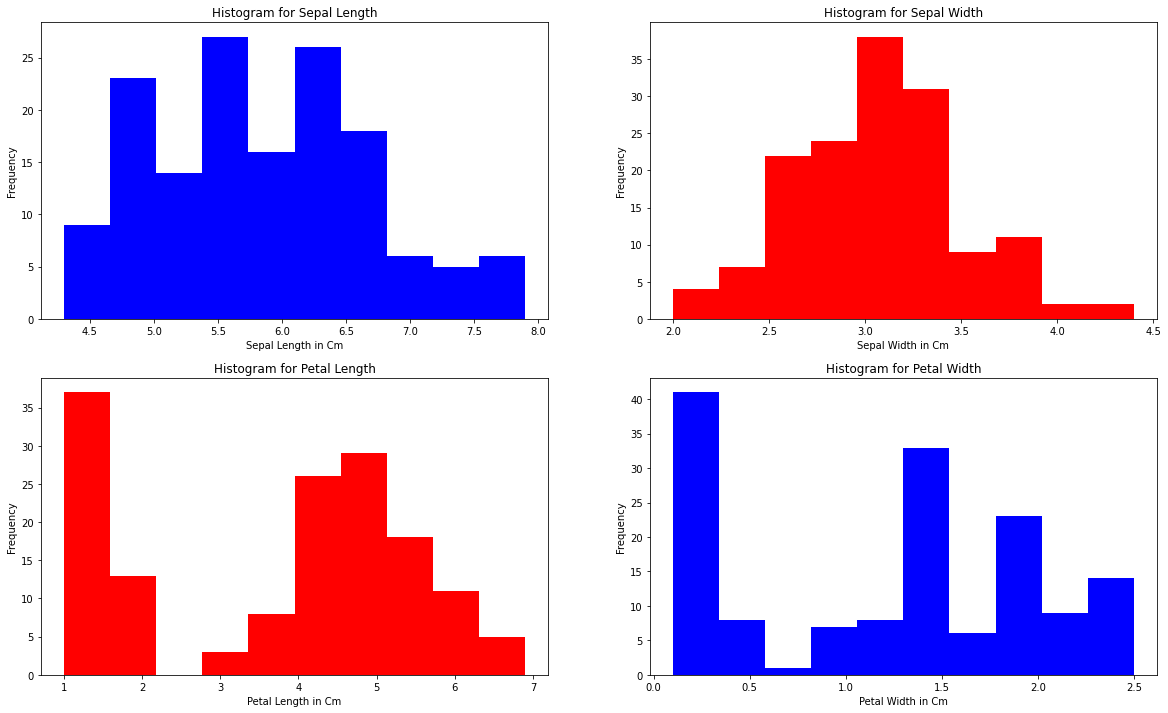

In [7]:
plt.figure(figsize=(20, 12))

plt.subplot(221) 
plt.hist(data['SepalLengthCm'],color = 'blue')
plt.xlabel('Sepal Length in Cm')
plt.ylabel('Frequency')
plt.title('Histogram for Sepal Length')

plt.subplot(222) 
plt.hist(data['SepalWidthCm'],color = 'red')
plt.xlabel('Sepal Width in Cm')
plt.ylabel('Frequency')
plt.title('Histogram for Sepal Width')

plt.subplot(223) 
plt.hist(data['PetalLengthCm'],color = 'red')
plt.xlabel('Petal Length in Cm')
plt.ylabel('Frequency')
plt.title('Histogram for Petal Length')

plt.subplot(224) 
plt.hist(data['PetalWidthCm'],color = 'blue')
plt.xlabel('Petal Width in Cm')
plt.ylabel('Frequency')
plt.title('Histogram for Petal Width')

plt.show()

> Sepal Width feature is Normally Distributed

### Pair Plot (Bivariate Analysis)

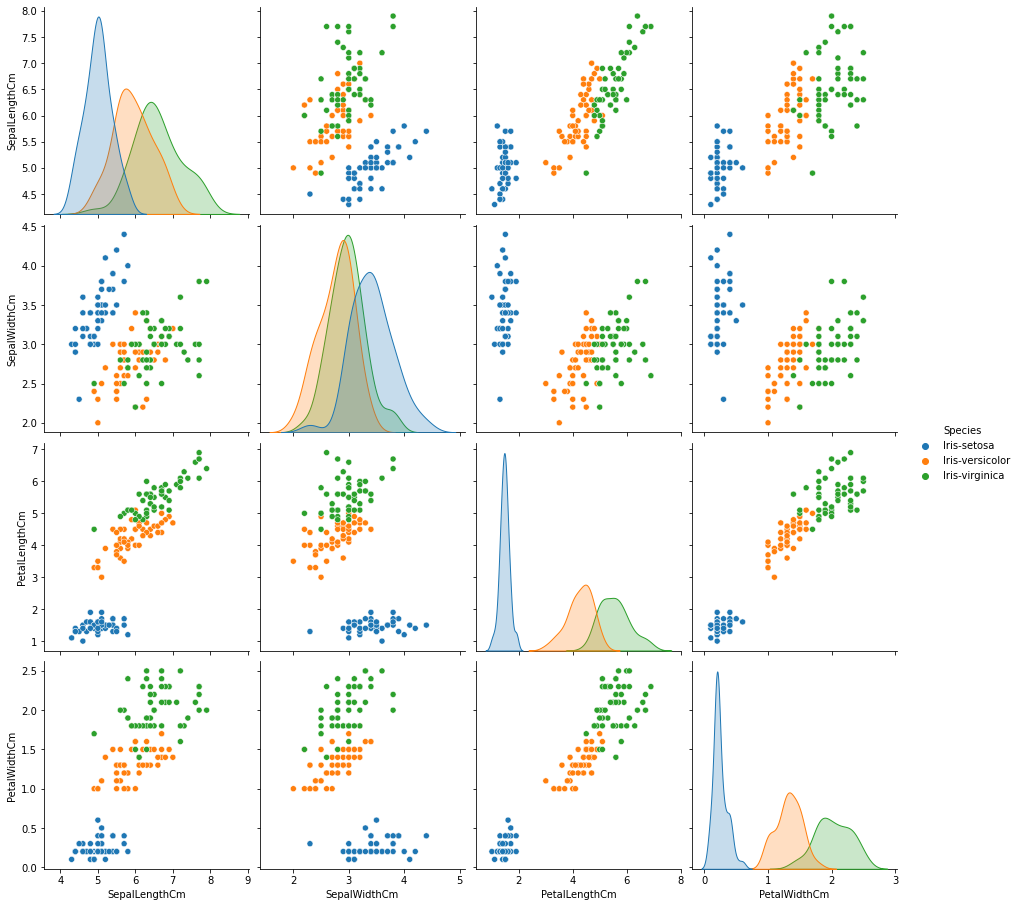

In [8]:
sns.pairplot(data.drop(columns = ['Id']), hue = "Species", size = 3.2)

### Scatter Plots 

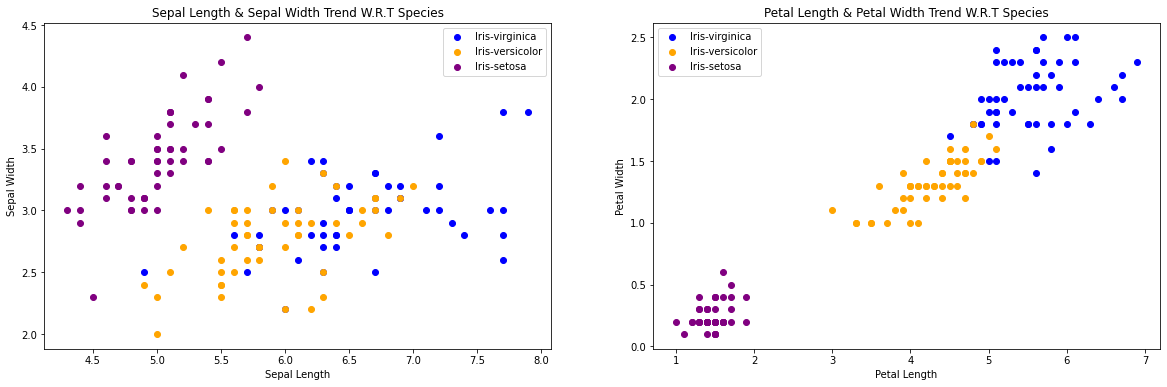

In [9]:
plt.figure(figsize=(20,6))

colors = ['blue','orange','purple']
species = ['Iris-virginica','Iris-versicolor', 'Iris-setosa']

plt.subplot(121) 

for i in range(3):
    x = data[data['Species'] == species[i]]
    plt.scatter(x['SepalLengthCm'],x['SepalWidthCm'],c=colors[i],label = species[i])
    
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Sepal Length & Sepal Width Trend W.R.T Species')
plt.legend()

plt.subplot(122) 

for i in range(3):
    x = data[data['Species'] == species[i]]
    plt.scatter(x['PetalLengthCm'],x['PetalWidthCm'],c=colors[i],label = species[i])
    
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Petal Length & Petal Width Trend W.R.T Species')
plt.legend()

plt.show()

> Sepal Length & Sepal Width have more overlappings whereas Petal Length & Petal Width have very few overlappings

### Co-relation Matrix

<AxesSubplot:>

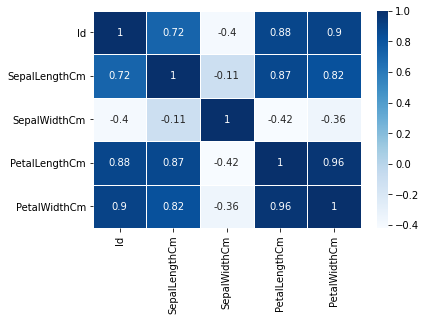

In [10]:
corr = data.corr()
fig,axis = plt.subplots(figsize = (6,4))
sns.heatmap(corr,annot = True, ax = axis,linewidths=.5,cmap="Blues")

> We Observe that the boxes with dark color are more corelated (Petal Width - Petal length)

# Label Encoding Categorical Data

In [11]:
le = LabelEncoder()

data['Species'] = le.fit_transform(data['Species'])

# Clustering

### Finding the optimal number of clusters for K-Means (Determining the value of K)

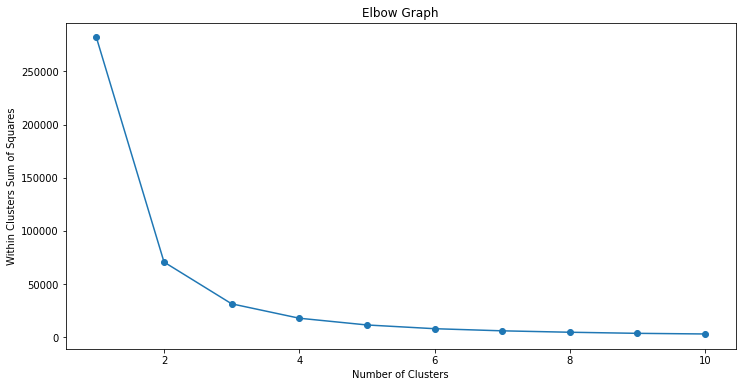

In [12]:
x = data.iloc[:, [0, 1, 2, 3, 4]].values

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12, 6))
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Clusters Sum of Squares')
plt.show()

> K = 1 to K = 2 (Steep Slope)

> K = 2 to K = 3 (Gentle Slope)

> K = 3 (Elbow Point)

In [13]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_kmeans = kmeans.fit_predict(x)

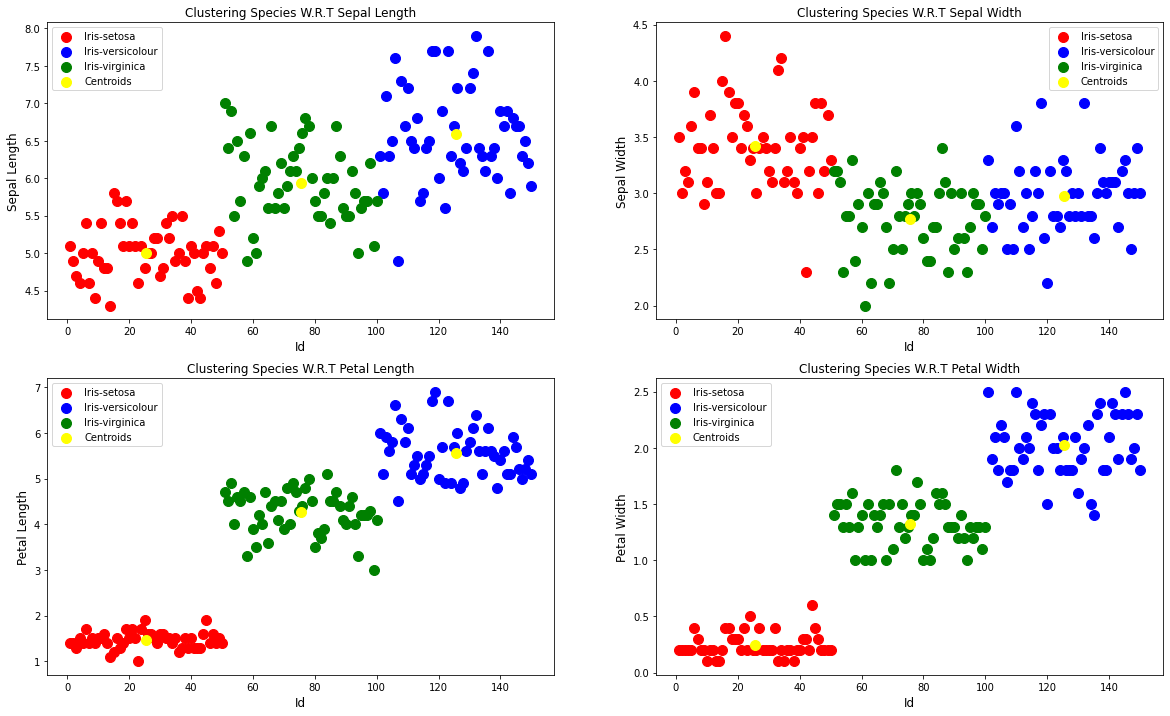

In [14]:
plt.figure(figsize=(20,12))

plt.subplot(221) 
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')
plt.xlabel('Id',size = 12)
plt.ylabel('Sepal Length',size = 12)
plt.title('Clustering Species W.R.T Sepal Length',size = 12)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

plt.subplot(222) 
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 2], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 2], s = 100, c = 'blue', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 2], s = 100, c = 'green', label = 'Iris-virginica')
plt.xlabel('Id',size = 12)
plt.ylabel('Sepal Width',size = 12)
plt.title('Clustering Species W.R.T Sepal Width',size = 12)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,2], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

plt.subplot(223) 
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 3], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 3], s = 100, c = 'blue', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 3], s = 100, c = 'green', label = 'Iris-virginica')
plt.xlabel('Id',size = 12)
plt.ylabel('Petal Length',size = 12)
plt.title('Clustering Species W.R.T Petal Length',size = 12)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,3], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

plt.subplot(224) 
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 4], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 4], s = 100, c = 'blue', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 4], s = 100, c = 'green', label = 'Iris-virginica')
plt.xlabel('Id',size = 12)
plt.ylabel('Petal Width',size = 12)
plt.title('Clustering Species W.R.T Petal Width',size = 12)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,4], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

plt.show()

> We Observe that the clusters are perfectly seperated when the k = 3

# Feature Selection

In [15]:
# Dropping id due to uniqueness
data = data.drop(['Id'], axis = 1) 
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Data Modeling

In [16]:
x = data.drop(columns = ['Species'])
y = data['Species']

x_train , x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

### KNN 

Train Accuracy:  95.238
Test Accuracy:  100.0


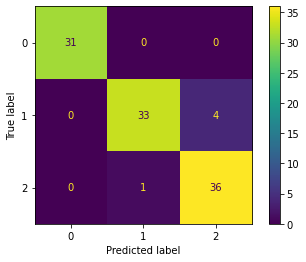

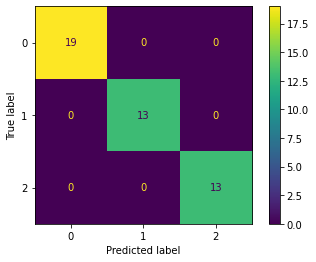

In [17]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

print("Train Accuracy: ",round(knn.score(x_train, y_train)*100, 3))
print("Test Accuracy: ",round(knn.score(x_test, y_test)*100, 3))

plot_confusion_matrix(knn, x_train, y_train)
plot_confusion_matrix(knn, x_test, y_test)

plt.show()

> Train Data: 5 records misclassified 

> Test Data: 0 records misclassified

### SVC

Train Accuracy:  96.19
Test Accuracy:  100.0


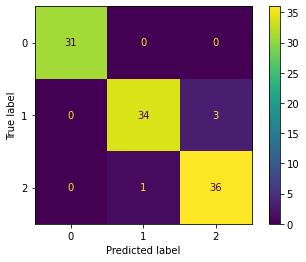

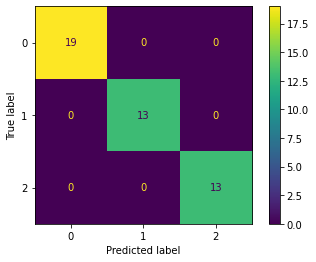

In [18]:
svc = SVC(random_state = 42)
svc.fit(x_train, y_train)

print("Train Accuracy: ",round(svc.score(x_train, y_train)*100, 3))
print("Test Accuracy: ",round(svc.score(x_test, y_test)*100, 3))

plot_confusion_matrix(svc, x_train, y_train)
plot_confusion_matrix(svc, x_test, y_test)

plt.show()

> Train Data: 4 records misclassified 

> Test Data: 0 records misclassified

### Decision Tree 

Train Accuracy:  100.0
Test Accuracy:  100.0


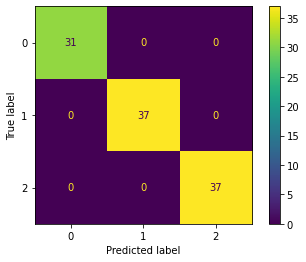

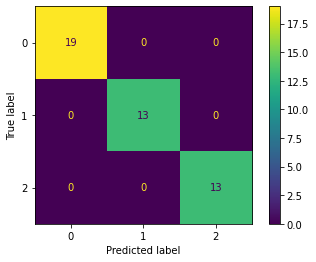

In [19]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(x_train, y_train)

print("Train Accuracy: ",round(dt.score(x_train, y_train)*100, 3))
print("Test Accuracy: ",round(dt.score(x_test, y_test)*100, 3))

plot_confusion_matrix(dt, x_train, y_train)
plot_confusion_matrix(dt, x_test, y_test)

plt.show()

> Train Data: 0 records misclassified 

> Test Data: 0 records misclassified

# Visualizing DT Graphically 

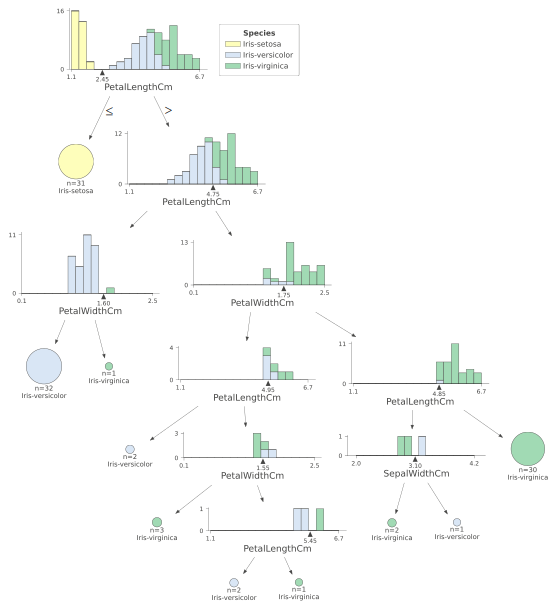

In [20]:
fn = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
graph = dtreeviz(dt, x_train, y_train,
                 target_name = "Species",
                 feature_names = fn,
                 class_names = list(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
graph

> This is graphical visual for the Decision Tree Clasifier

> Gini Index is used by the Classifier for the best splitting of nodes

# Conclusion

> #### 1. K - Means Clustering performed well with k = 3.

> #### 2. Decision Tree Classifier performed best. 

> #### 3. Visualized DTC Graphically.